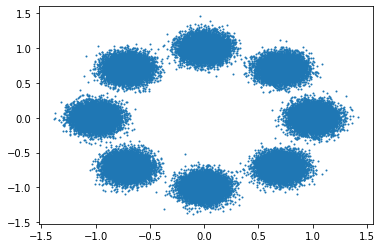

In [1]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # return self.data[idx], self.label[idx]
        return self.data[idx]

data_size = 80000
dataset = CustomDataSet(n_group=8, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [0]:
class NormalDensityNetwork(torch.nn.Module):

    def __init__(self, n_in, n_out):
        super(NormalDensityNetwork, self).__init__()
        self.mean = torch.nn.Linear(in_features=n_in, out_features=n_out, bias=True)
        self.log_var = torch.nn.Linear(in_features=n_in, out_features=n_out, bias=True)

    def forward(self, x):
        return self.mean(x), torch.exp(0.5 * self.log_var(x))



def forwardKL_by(eps, sampler_mu, sampler_sig, mu, sig): #KL(N(tar_mu, tar_sig) || N(self.mu, self.sig))
    forward_kl = torch.log(sig) - torch.log(sampler_sig) + 0.5 * (((sampler_sig * eps + sampler_mu - mu)/(sig))**2 -  eps* eps)
    return torch.sum(forward_kl, dim=1).mean()


def forwardKL(tar_mu, tar_sig, mu, sig): #KL(N(tar_mu, tar_sig) || N(self.mu, self.sig))
    forward_kl = torch.log(sig) - torch.log(tar_sig) + ((tar_sig * tar_sig + (tar_mu - mu) * (tar_mu - mu)) / (2.0 * sig * sig)) - 0.5
    return torch.sum(forward_kl, dim=1).mean()


def reverseKL_STD(mu, sig): #KL(N(self.mu, self.sig) || N(0, I))
    reverse_kl = -torch.log(sig) + (sig * sig + mu * mu) / 2.0 - 0.5
    return torch.sum(reverse_kl, dim=1).mean()

def reverseKL_STD_by(eps, mu, sig): #KL(N(self.mu, self.sig) || N(0, I))
    reverse_kl = -torch.log(sig) + 0.5 * ((sig * eps + mu)**2.0 - eps * eps )
    return torch.sum(reverse_kl, dim=1).mean()


def reverseKL(mu, sig, tar_mu, tar_sig): #KL(N(self.mu, self.sig) || N(tar_mu, tar_sig))
    reverse_kl = torch.log(tar_sig) - torch.log(sig) + ((sig * sig + (mu - tar_mu) * (mu - tar_mu)) / (2.0 * tar_sig * tar_sig)) - 0.5
    return torch.sum(reverse_kl, dim=1).mean()


def log_likelihood(x, mu, sig):
    return -torch.sum(torch.log(sig) + 0.5 * (np.log(2.0 * np.pi) + ((mu - x)/sig)**2), dim=1).mean()


def randnLike(tensor):
    return torch.randn_like(tensor)


def stop_grad(x):
    return torch.from_numpy(x.data.numpy())

In [0]:
X_dim = 2
C_dim = 2
Z_dim = 2
mb_size = 64
Qc = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=C_dim))


Qz = torch.nn.Sequential(
    torch.nn.Linear(C_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=Z_dim))


Pc = torch.nn.Sequential(
    torch.nn.Linear(Z_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=C_dim))


Px = torch.nn.Sequential(
    torch.nn.Linear(C_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=X_dim))

Qc_solver = optim.Adam(Qc.parameters(), lr=1e-3)
Qz_solver = optim.Adam(Qz.parameters(), lr=1e-3)
Pc_solver = optim.Adam(Pc.parameters(), lr=1e-3)
Px_solver = optim.Adam(Px.parameters(), lr=1e-3)

In [0]:
ELBO = []
NLL = []
loader = DataLoader(dataset, batch_size=mb_size, shuffle=True, drop_last=True)

In [37]:
num_epochs = 100
for epoch in range(num_epochs):
    ELBO_CUM = 0.0
    NLL_CUM = 0.0
    KLD_CUM = 0.0
    for _, X in enumerate(loader):
        Qc_solver.zero_grad()
        Qz_solver.zero_grad()
        Pc_solver.zero_grad()
        Px_solver.zero_grad()
        
        qcx_mu, qcx_sig = Qc(X)
        qcx_eps = randnLike(qcx_sig)
        qcx = qcx_mu + qcx_eps * qcx_sig

        qzc_mu, qzc_sig = Qz(qcx)
        qzc_eps = randnLike(qzc_sig)

        pcz_mu, pcz_sig = Pc(qzc_mu + qzc_eps * qzc_sig)
        pxc_mu, pxc_sig = Px(qcx)

        prior_kld = reverseKL_STD_by(qzc_eps, qzc_mu, qzc_sig)
        forward_kld = forwardKL_by(qcx_eps, qcx_mu, qcx_sig, pcz_mu, pcz_sig) 
        evidence_ll = log_likelihood(X, pxc_mu, pxc_sig)

        loss = 1.0 * ( prior_kld + forward_kld ) - 1.0 * evidence_ll
        loss.backward()

        KLD_CUM += prior_kld.item()
        Qc_solver.step()
        Qz_solver.step()
        Pc_solver.step()
        Px_solver.step()
        NLL_CUM -= evidence_ll.item()
        # ELBO_CUM  += pxc_ll.item() - prior_kld.item() - forward_kld.item()
    NLL.append(NLL_CUM / len(loader))
    # ELBO.append(ELBO_CUM / len(loader))
    print(NLL[-1])

-2.0554208567619323
-2.0521065563201906
-2.059211897659302
-2.055907375717163
-2.0533409443855284
-2.0449049199104308
-2.0514967240333557
-2.06085229177475
-2.049149246788025
-2.0530273386001587
-2.050983330154419
-2.0480199314117433
-2.053482435131073
-2.0470026311874387
-2.045752789402008
-2.0504839852333068
-2.0439092458724977
-2.0464539885520936
-2.047091861820221
-2.056389239406586
-2.0574977160215377
-2.0547429514884947
-2.0519532749176026
-2.037187934398651
-2.0497903188705444
-2.042853656673431
-2.0313554944038392
-2.045603384780884
-2.0596280219554903
-2.061517075872421
-2.057675092411041
-2.0597697447776793
-2.0637922131538393
-2.0502839582443237
-2.0662692608833315
-2.047326947593689
-2.0527082125663756
-2.054230664587021
-2.0641813311576844
-2.0498596512794496
-2.053955113887787
-2.0478653509140017
-2.051135043621063
-2.051194258022308
-2.0473413083076477
-2.0461486680030823
-2.061799796104431
-2.0619225246191024
-2.05805509185791
-2.049166921520233
-2.0455728702545164
-2.0

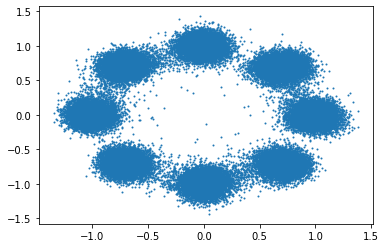

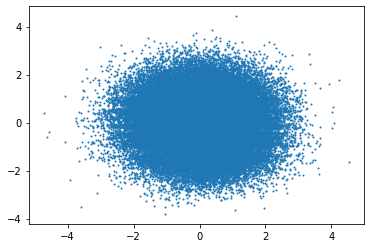

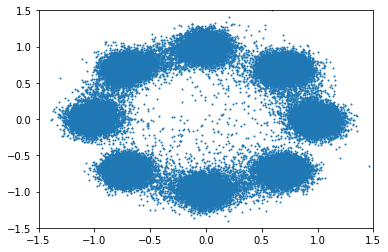

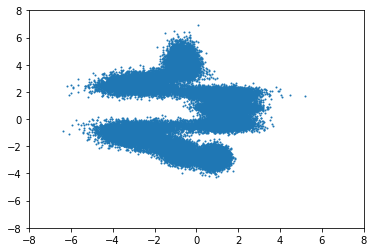

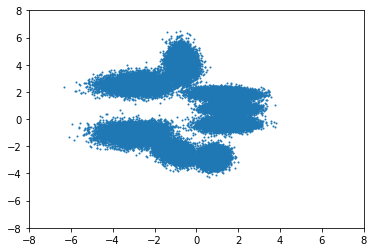

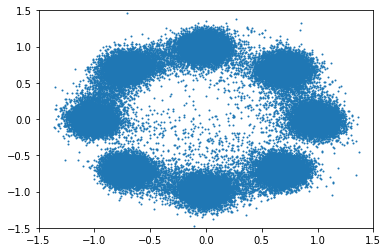

In [42]:
qcx_mu, qcx_sig = Qc(dataset.data)
qcx_eps = randnLike(qcx_sig)
qcx = qcx_mu + qcx_eps * qcx_sig
qzc_mu, qzc_sig = Qz(qcx)
qzc = qzc_mu + qzc_sig * randnLike(qzc_sig)
pcz_mu, pcz_sig = Pc(qzc)
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(qcx)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

qzc = qzc.data.numpy()
plt.scatter(qzc[:,0], qzc[:,1], s=1)
plt.show()

pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

pcz = pcz.data.numpy()
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.scatter(pcz[:,0], pcz[:,1], s=1)
plt.show()


plt.xlim(-8, 8)
plt.ylim(-8, 8)
qcx = qcx.data.numpy()
plt.scatter(qcx[:,0], qcx[:,1], s=1)
plt.show()

pcz_mu, pcz_sig = Pc(randnLike(qzc_sig))
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)

pxc = pxc.data.numpy()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()


In [0]:
D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1, bias=True),
    torch.nn.Sigmoid())
D_solver = optim.Adam(D.parameters(), lr=1e-3)

ones_label = torch.ones(mb_size, 1)
zeros_label = torch.zeros(mb_size, 1)

In [76]:
num_epochs = 100
for epoch in range(num_epochs):
    ELBO_CUM = 0.0
    NLL_CUM = 0.0
    KLD_CUM = 0.0
    for _, X in enumerate(loader):

        D_solver.zero_grad()
        D_real = D(X)

        pcz_mu, pcz_sig = Pc(torch.randn(mb_size, Z_dim))
        pxc_mu, pxc_sig = Px(pcz_mu + randnLike(pcz_sig) * pcz_sig)
    
        D_fake = D(pxc_mu + pxc_sig * randnLike(pxc_sig))
        D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
        (D_loss_real + D_loss_fake).backward()
        D_solver.step()



        Qc_solver.zero_grad()
        Qz_solver.zero_grad()
        Pc_solver.zero_grad()
        Px_solver.zero_grad()
        
        qcx_mu, qcx_sig = Qc(X) 
        qcx_eps = randnLike(qcx_sig)
        qcx = qcx_mu + qcx_eps * qcx_sig

        qzc_mu, qzc_sig = Qz(qcx)
        qzc_eps = randnLike(qzc_sig)

        pcz_mu, pcz_sig = Pc(qzc_mu + qzc_eps * qzc_sig)
        pxc_mu, pxc_sig = Px(qcx)

        prior_kld = reverseKL_STD_by(qzc_eps, qzc_mu, qzc_sig)
        forward_kld = forwardKL_by(qcx_eps, qcx_mu, qcx_sig, pcz_mu, pcz_sig) 
        evidence_ll = log_likelihood(X, pxc_mu, pxc_sig)

        pcz_mu, pcz_sig = Pc(torch.randn(mb_size, Z_dim))
        pxc_mu, pxc_sig = Px(pcz_mu + randnLike(pcz_sig) * pcz_sig)
        D_loss = nn.binary_cross_entropy(D(pxc_mu + pxc_sig * randnLike(pxc_sig)), ones_label)

        loss = 1.0 * (5.0 * prior_kld + forward_kld ) - 1.0 * evidence_ll + D_loss
        # loss = 1.0 * (3.0 * prior_kld + forward_kld ) - 1.0 * evidence_ll  
        loss.backward()

        KLD_CUM += prior_kld.item()
        Qc_solver.step()
        Qz_solver.step()
        Pc_solver.step()
        Px_solver.step()
        NLL_CUM -= evidence_ll.item()
        # ELBO_CUM  += pxc_ll.item() - prior_kld.item() - forward_kld.item()
    NLL.append(NLL_CUM / len(loader))
    # ELBO.append(ELBO_CUM / len(loader))
    print(NLL[-1], KLD_CUM/len(loader))

-3.6093869377613066 0.0002716082878469024
-3.6016475456237793 0.00017419873918406666
-3.6212852968215943 0.0003239522730349563
-3.617976231908798 0.00027158539435476995
-3.641735032081604 0.00023670801418484188
-3.6158106696128844 0.00019976109199924396
-3.6132881936073304 0.00018425113506964408
-3.599178915452957 0.00022528956095920876
-3.6428390018939973 0.00025321294283494353
-3.6282901693344116 0.0003397377529036021
-3.627909087586403 0.00018293377421214245
-3.682512817955017 0.00015110615816665813
-3.7379442947387695 0.00023287306721904316
-3.6559692642211914 0.00015811298009939492
-3.6356265749931334 0.00020143107787589542
-3.6144683270454405 0.00016414087653975003
-3.6219654673576356 0.0002636863689636812
-3.6520707991600037 0.0004258267202065326
-3.6716175830841062 0.0002587037433811929
-3.655993043613434 0.0002844052663189359
-3.6398537858963014 0.00027516683661961
-3.6106234018325805 0.0002866764779842924
-3.571911583518982 0.00015236240593949333
-3.5894336606025696 0.0001235

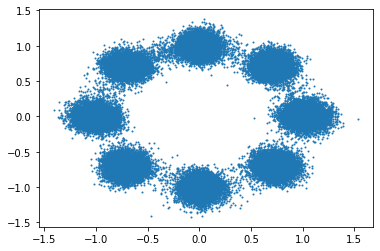

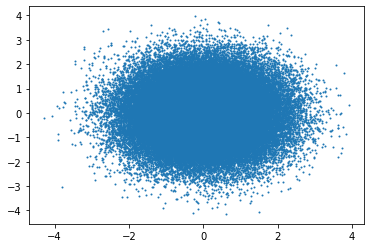

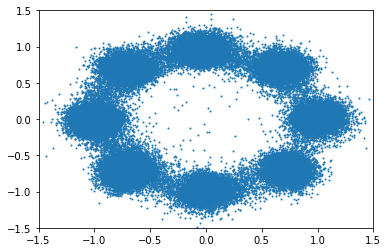

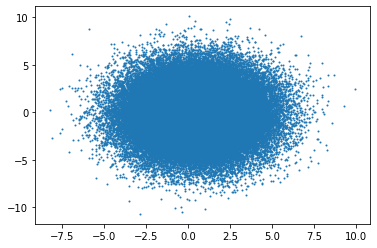

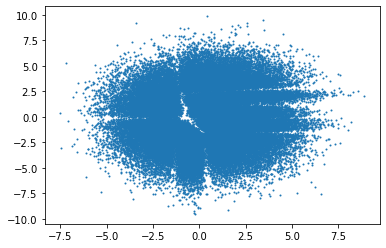

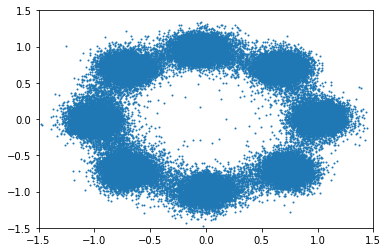

In [77]:
qcx_mu, qcx_sig = Qc(dataset.data)
qcx_eps = randnLike(qcx_sig)
qcx = qcx_mu + qcx_eps * qcx_sig
qzc_mu, qzc_sig = Qz(qcx)
qzc = qzc_mu + qzc_sig * randnLike(qzc_sig)
pcz_mu, pcz_sig = Pc(qzc)
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(qcx)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

qzc = qzc.data.numpy()
plt.scatter(qzc[:,0], qzc[:,1], s=1)
plt.show()

pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

pcz = pcz.data.numpy()
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.scatter(pcz[:,0], pcz[:,1], s=1)
plt.show()


# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
qcx = qcx.data.numpy()
plt.scatter(qcx[:,0], qcx[:,1], s=1)
plt.show()

pcz_mu, pcz_sig = Pc(randnLike(qzc_sig))
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)

pxc = pxc.data.numpy()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()
